# Centrality in actor graph and popularity. Are they linked?

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pydot
import itertools
from utils import get_or_init_pickle

We want to use wikipedia pageviews as a proxy for popularity, and try to find a correlation the centrality of actors in the actor graph. For this we used the [dataset of pageviews](https://github.com/epfl-ada/2022/blob/main/Homework/02%20-%20Regression%20Observational%20Studies%20Stats%20and%20Supervised%20Learning/data/all_entities.csv.gz) from Homework 2. Since Wikipedia was founded at the start of the century, pageviews might not be relevant for older actors. To eliminate this possible bias we only considered only actors having played in recent movies and formed the actor-graph only based on the recent movies.

In [7]:
df_roles = pd.read_pickle("../data/generated/preprocessed/roles.pkl")
edges = []

recent_roles = df_roles.loc[df_roles.release_year >= 2005].dropna(subset=['fb_actor_id'])

for movie_fbid, df_actor_movie in recent_roles.groupby('fb_movie_id'):
	# NOTE : we need to sort the edges, because we only store i -> j, but want an undirected graph
	# NOTE : we need to use unique(), because some actors play multiple characters in the same movie
	# e.g. df_actors.query('fb_movie_id == "/m/011xrr"')
	edges += [ (*sorted((actor1_fbid, actor2_fbid)), movie_fbid )
		for actor1_fbid, actor2_fbid 
              in itertools.combinations(df_actor_movie.fb_actor_id.unique(), r=2) ]

df_edges = pd.DataFrame(edges, columns=['actor1_fbid', 'actor2_fbid', 'movie_fbid'])

# sanity check that we indeed have ordered edges
assert (df_edges['actor1_fbid'] < df_edges['actor2_fbid']).all()

In [11]:
df_edges_grouped = (df_edges
	.groupby(['actor1_fbid', 'actor2_fbid'])
	[['movie_fbid']]
	.count()
	.reset_index()
	.sort_values('movie_fbid', ascending=False)  # movie_fbid count is the edge weight !!
)

df_edges_grouped.rename(columns={'movie_fbid': 'movie_count'}, inplace=True)

In [12]:
df_actors = pd.read_pickle("../data/generated/preprocessed/actors.pkl")
df_actors = df_actors.loc[df_actors.actor_name.notna()]
actor_graph = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
actor_graph = actor_graph.subgraph(df_actors.fb_actor_id).copy()

In [13]:
# a mapping from freebaseid to actor names
fbid2name = dict((row.fb_actor_id, row.actor_name) for _, row in df_actors.iterrows())
fbid2name_newline = dict((row.fb_actor_id, row.actor_name.replace(' ', '\n')) for _, row in df_actors.iterrows())  # for displaying graphs

actor_graph_names = nx.relabel_nodes(actor_graph, fbid2name)

In [14]:
# create a list of connected components
actor_graph_comps = [actor_graph.subgraph(c).copy() for c in nx.connected_components(actor_graph)]
actor_subgraph = max(actor_graph_comps, key=lambda G: G.number_of_nodes())
actor_subgraph_names = nx.relabel_nodes(actor_subgraph, fbid2name_newline)

In [29]:
actors = set(actor_subgraph.nodes())
nactors = len(actors)
nmovies = df_roles[df_roles.fb_actor_id.apply(lambda x: x in actors)].fb_movie_id.nunique()
nactors_with_pageviews = df_actors[df_actors.fb_actor_id.apply(lambda x: x in actors)].pageviews.count()

print("We therefore consider %d actors accross %d movies, %d of which (the actors) \
we have the pageview count"%(nactors, nmovies, nactors_with_pageviews))

We therefore consider 49481 actors accross 41039 movies, 4631 of which (the actors) we have the pageview count


## Computing centrality

We focused on three metrics of centrality:
- Degree centrality: With how many other actors have the actors played
- Eigenvector centrality
- Betweenness: how much an actor bridges communities of actors

In [30]:
degree_centrality = nx.degree_centrality(actor_subgraph)
eigenvector_centrality = nx.eigenvector_centrality(actor_subgraph)
betweenness_centrality = nx.betweenness_centrality(actor_subgraph, k=300)

In [31]:
df_centrality = pd.DataFrame(degree_centrality.items(), columns=['fb_actor_id', 'degree_centrality'])
df_centrality = df_centrality.merge(pd.DataFrame(eigenvector_centrality.items(), columns=['fb_actor_id', 'eigenvector_centrality']), on='fb_actor_id', how='left')
df_centrality = df_centrality.merge(pd.DataFrame(betweenness_centrality.items(), columns=['fb_actor_id', 'betweenness_centrality']), on='fb_actor_id', how='left')
df_centrality['actor_name'] = df_centrality.fb_actor_id.map(lambda i: fbid2name[i])

### Who are the most central actors

For those interested, we list here the most central actors.

In [32]:
df_centrality.sort_values('degree_centrality', ascending=False)[['degree_centrality', 'actor_name', 'fb_actor_id']].head(5)

,degree_centrality,actor_name,fb_actor_id
70,0.011601,Anupam Kher,/m/0292l3
744,0.010853,Jane Lynch,/m/07m77x
748,0.010287,Samuel L. Jackson,/m/0f5xn
710,0.009903,David Koechner,/m/059j1m
202,0.009863,Justin Long,/m/07cjqy


In [33]:
df_centrality.sort_values('eigenvector_centrality', ascending=False)[['eigenvector_centrality', 'actor_name']].head(5)

,eigenvector_centrality,actor_name
1150,0.095907,David Strathairn
6434,0.095699,Nicole Kidman
4889,0.095603,Clive Owen
6102,0.094613,Parker Posey
4467,0.094151,Rodrigo Santoro


In [34]:
df_centrality.sort_values('betweenness_centrality', ascending=False)[['betweenness_centrality', 'actor_name']].head(5)

,betweenness_centrality,actor_name
70,0.017395,Anupam Kher
5728,0.012934,Lee Byung-Hun
3154,0.011948,Rade Serbedzija
1032,0.011301,Stellan Skarsgård
256,0.009833,Irrfan Khan


## Comparing centrality to pageviews

In [44]:
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Naïve visualisation

We first try to visualise the two values together.

In [35]:
df_actors.index = df_actors.fb_actor_id

For degree centrality;
	We find an average increase of 57.248% in pageviews per 10x increase in centrality
For eigenvector centrality;
	We find an average increase of 13.791% in pageviews per 10x increase in centrality
For betweenness centrality;
	We find an average increase of 14.640% in pageviews per 10x increase in centrality


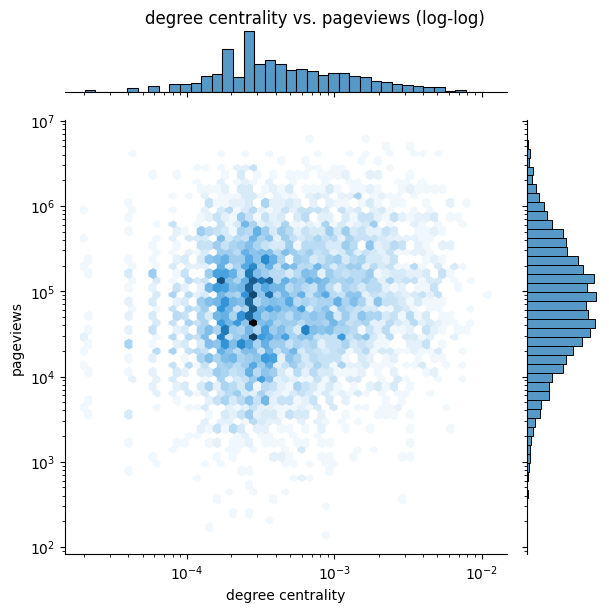

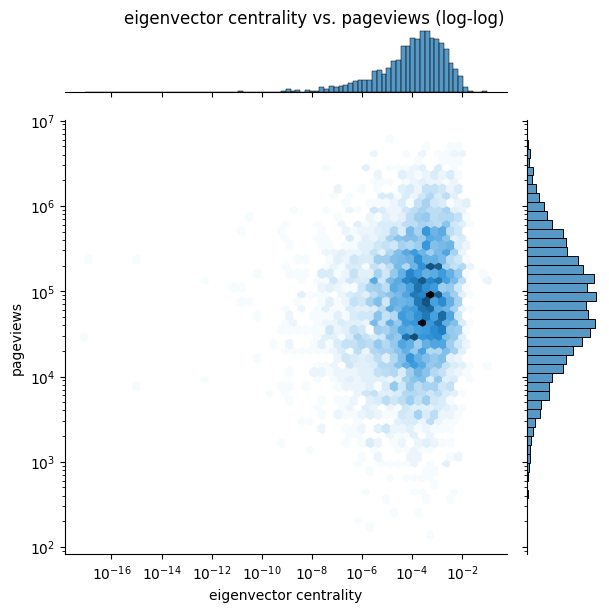

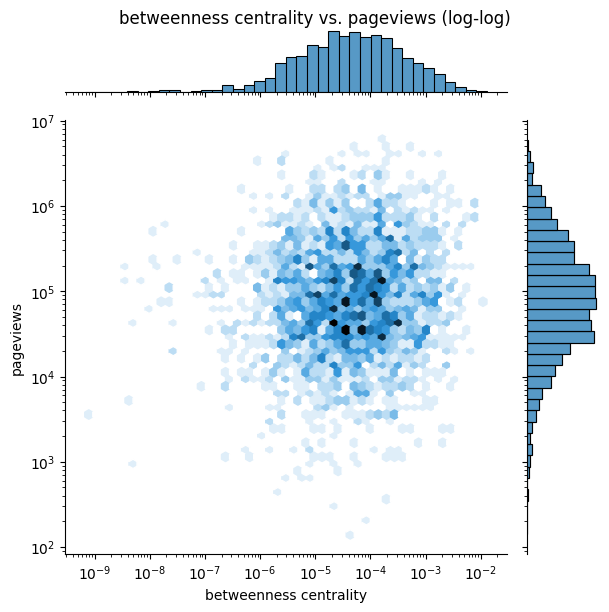

In [104]:
r_squared = {}
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality],
                ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if 
                  not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if 
                 not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    g = sns.jointplot(x=centrality, y=pageviews, kind="hex", xscale="log", yscale="log")
    g.fig.suptitle(t.replace("_", " ") + " vs. pageviews (log-log)")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.set_axis_labels(t.replace("_", " "),"pageviews")
    
    model = smf.ols(formula="pageviews ~ centrality", 
                    data={
                        "pageviews": np.log10(np.array(pageviews)),
                        "centrality": np.log10(np.array(centrality))
                    })

    np.random.seed(83)
    res = model.fit()
    
    increase = math.pow(10,res.params["centrality"]) * 100 -100
    r_squared[t] = float(res.summary().tables[0].data[0][3].strip()) * 100

    print("For %s.\n\tWe find an average increase of %.3f%% in pageviews per 10x increase in centrality" % (t.replace("_", " "), increase))

The correlations we found were very modest with R^2 values of 0.016, 0.013, and 0.007 respectively

### The impact of movie count

In [107]:
movie_counts = df_roles.groupby(by=["fb_actor_id"]).fb_movie_id.nunique()
df_actors["movie_count"] = movie_counts

For movie count.
	We find an average increase of 50.742% in pageviews per 10x increase in movie count


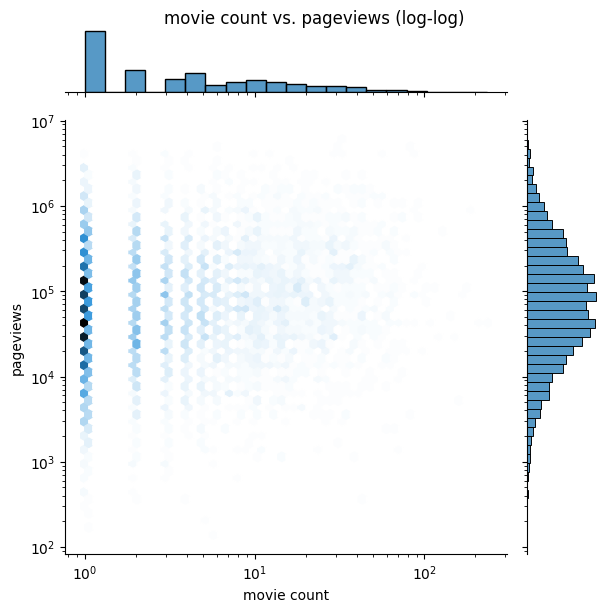

In [124]:
t = "movie_count"
movie_counts = [df_actors.movie_count[node] for node in actor_subgraph.nodes() if 
              not pd.isna(df_actors.pageviews[node]) and df_actors.movie_count[node] > 0]
pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if 
             not pd.isna(df_actors.pageviews[node]) and df_actors.movie_count[node] > 0]
g = sns.jointplot(x=movie_counts, y=pageviews, kind="hex", xscale="log", yscale="log")
g.fig.suptitle(t.replace("_", " ") + " vs. pageviews (log-log)")
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.set_axis_labels(t.replace("_", " "),"pageviews")

model = smf.ols(formula="pageviews ~ movie_count", 
                data={
                    "pageviews": np.log10(np.array(pageviews)),
                    "movie_count": np.log10(np.array(movie_counts))
                })

np.random.seed(83)
res = model.fit()

increase = math.pow(10,res.params["movie_count"]) * 100 -100

print("For %s.\n\tWe find an average increase of %.3f%% in pageviews per 10x increase in movie count" % (t.replace("_", " "), increase))

For degree centrality.
	We find an average increase of 3.7x in centrality per 10x increase in movie count
For eigenvector centrality.
	We find an average increase of 19.8x in centrality per 10x increase in movie count
For betweenness centrality.
	We find an average increase of 10.5x in centrality per 10x increase in movie count


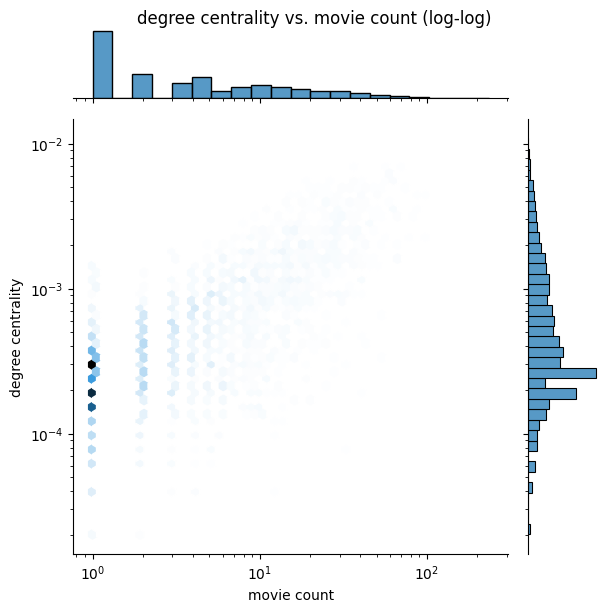

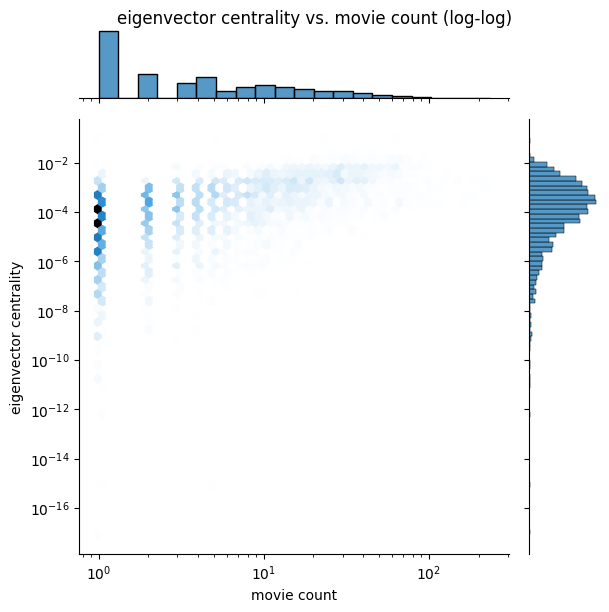

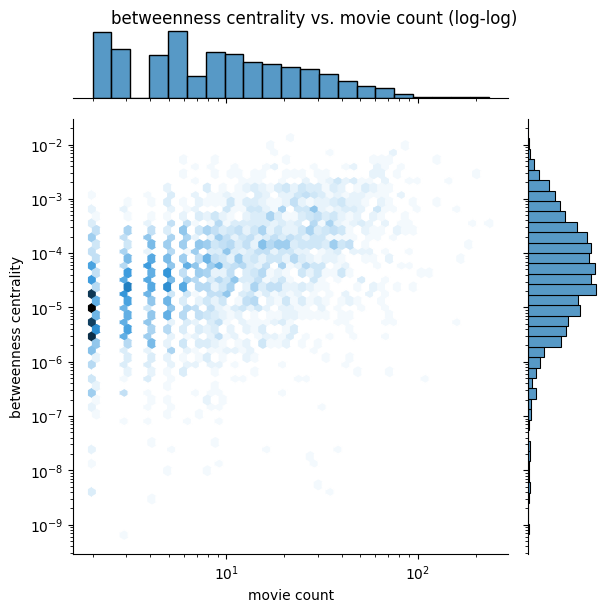

In [120]:
r_squared = {}
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    movies = [df_actors.movie_count[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    g = sns.jointplot(x=movies, y=centrality, kind="hex", xscale="log", yscale="log")
    
    g.fig.suptitle(t.replace("_", " ") + " vs. movie count (log-log)")
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.set_axis_labels("movie count",t.replace("_", " "))

    model = smf.ols(formula="centrality ~ movie_count", 
                    data={
                        "centrality": np.log10(np.array(centrality)),
                        "movie_count": np.log10(np.array(movies))
                    })

    np.random.seed(83)
    res = model.fit()

    increase = math.pow(10,res.params["movie_count"])
    r_squared[t] = float(res.summary().tables[0].data[0][3].strip())

    print("For %s.\n\tWe find an average increase of %.1fx in centrality per 10x increase in movie count" % (t.replace("_", " "), increase))

Here the values are better correlated, with R^2 values of 0.479, 0.263, and 0.212 respectively.
Movie count having a significant correlation with pageviews as well as with centrality, it acts as a confounder. We therefore aim to isolate the effects of centrality from those of movie count by using A/B testing